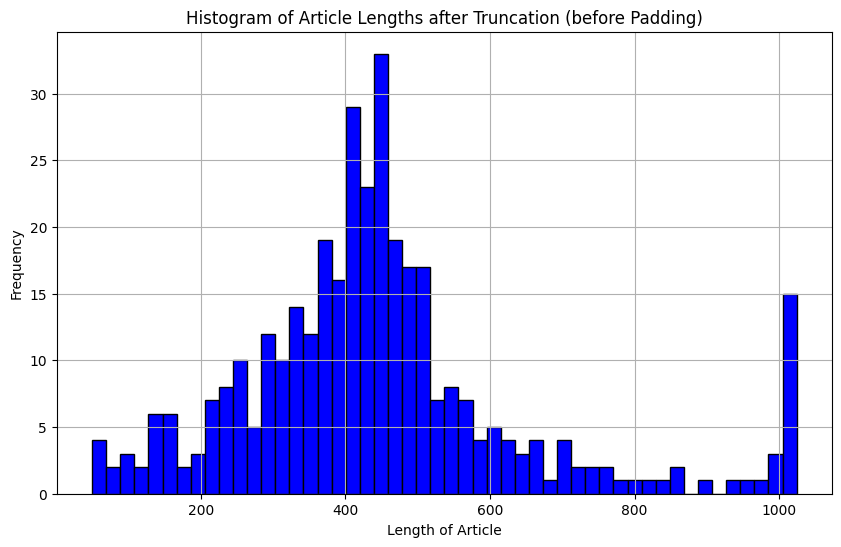

Shape of X [B, N]: torch.Size([8, 1024])
Shape of y: torch.Size([8]) torch.int64
| epoch   1 |     5/   45 batches | accuracy    0.542
| epoch   1 |    10/   45 batches | accuracy    0.425
| epoch   1 |    15/   45 batches | accuracy    0.500
| epoch   1 |    20/   45 batches | accuracy    0.575
| epoch   1 |    25/   45 batches | accuracy    0.575
| epoch   1 |    30/   45 batches | accuracy    0.575
| epoch   1 |    35/   45 batches | accuracy    0.625
| epoch   1 |    40/   45 batches | accuracy    0.625
-----------------------------------------------------------
| end of epoch   1 | time:  1.03s | valid accuracy    0.605 
-----------------------------------------------------------
| epoch   2 |     5/   45 batches | accuracy    0.625
| epoch   2 |    10/   45 batches | accuracy    0.475
| epoch   2 |    15/   45 batches | accuracy    0.625
| epoch   2 |    20/   45 batches | accuracy    0.575
| epoch   2 |    25/   45 batches | accuracy    0.625
| epoch   2 |    30/   45 batches | 

In [24]:


import torch
import pandas as pd
import numpy as np
from torchtext.data.utils import get_tokenizer
from torch.utils.data import Dataset
from torchtext.vocab import build_vocab_from_iterator
from torch.utils.data import DataLoader
from torch import nn
import time
import torchvision.transforms as T
import matplotlib.pyplot as plt
import os
# 切换到指定路径
os.chdir("E:/project_2024/CMU_10423/CMU_10423_2024S/HW0")

# 超参数设置
EPOCHS = 5  # 训练的轮数
LR = 5  # 学习率
BATCH_SIZE = 8  # 每次训练的批量大小
EMBED_DIM = 64 # 词嵌入的维度
MAX_LEN = 1024 # 文本输入的最大长度

# 获取训练所使用的设备，如果有GPU则使用GPU，否则使用CPU
device = (
    "cuda"  # 如果有可用的CUDA GPU
    if torch.cuda.is_available()
    else "cpu"  # 否则使用CPU
)

# 自定义数据集类，用于加载CSV文件中的文本数据
class CsvTextDataset(Dataset):
    def __init__(self, csv_file, transform=None):
        self.data_frame = pd.read_csv(csv_file)  # 读取CSV文件
        self.transform = transform  # 数据预处理

    def __len__(self):
        return len(self.data_frame)  # 返回数据集的长度

    def __getitem__(self, idx):
        if idx >= self.__len__(): 
            raise IndexError()  # 如果索引超出范围，则抛出索引错误
        text = self.data_frame.loc[idx, "article"]  # 获取文本数据
        label = self.data_frame.loc[idx, "label_idx"]  # 获取标签数据

        if self.transform:
            text = self.transform(text)  # 如果有预处理，则应用预处理

        return text, label  # 返回文本和标签

# 语料信息类，用于处理词汇表和标签等信息
class CorpusInfo():
    def __init__(self, dataset, tokenizer):
        self.dataset = dataset  # 数据集
        self.tokenizer = tokenizer  # 分词器
        self.oov_token = '<UNK>'  # 未知词的标记
        self.pad_token = '<PAD>'  # 填充的标记
        
        def yield_tokens(data_iter):
            for text, _ in data_iter:
                yield tokenizer(text)  # 对文本进行分词
        self.vocab = build_vocab_from_iterator(yield_tokens(dataset), specials=[self.oov_token, self.pad_token])  # 构建词汇表
        self.vocab.set_default_index(self.vocab[self.oov_token])  # 设置默认的索引为未知词
        
        self.oov_idx = self.vocab[self.oov_token]  # 获取未知词的索引
        self.pad_idx = self.vocab[self.pad_token]  # 获取填充词的索引
        
        self.vocab_size = len(self.vocab)  # 词汇表的大小
        self.num_labels = len(set([label for (text, label) in dataset]))  # 标签的数量

# 文本转换类，进行分词和数字化
class TextTransform(torch.Callable):
    def __init__(self, tokenizer, vocab):
        self.tokenizer = tokenizer  # 分词器
        self.vocab = vocab  # 词汇表

    def tokenize_and_numericalize(self, text):
        tokens = self.tokenizer(text)  # 将文本分词
        return [self.vocab[token] for token in tokens]  # 将词汇转化为索引

    def __call__(self, text):
        return self.tokenize_and_numericalize(text)  # 调用时进行分词和数字化
    
# 限制文本长度的类
class MaxLen(torch.Callable):
    def __init__(self, max_len):
        self.max_len = max_len  # 设置最大长度
        
    def __call__(self, x):
        if len(x) > self.max_len:
            x = x[:self.max_len]  # 如果文本长度超过最大长度，进行截断
        return x
    
    
    
# 填充序列的类，将不等长的序列填充到相同长度
class PadSequence(torch.Callable):
    def __init__(self, pad_idx):
        self.pad_idx = pad_idx  # 填充的索引
        
    def __call__(self, batch):
        def to_int_tensor(x):
            return torch.from_numpy(np.array(x, dtype=np.int64, copy=False))  # 将序列转换为Tensor
        sequences = [to_int_tensor(x[0]) for x in batch]  # 转换每个序列
        labels = to_int_tensor([x[1] for x in batch])  # 转换标签
        sequences_padded = torch.nn.utils.rnn.pad_sequence(sequences, batch_first=True, padding_value=self.pad_idx)  # 进行填充
        return sequences_padded, labels  # 返回填充后的序列和标签




# 获取数据函数，用于加载训练、验证和测试数据
def get_data():    
    
    train_data = CsvTextDataset(
        csv_file='./data/txt_train.csv',  # 训练数据文件路径
        transform=None,  # 不进行预处理
    )
    
    tokenizer = get_tokenizer("basic_english")  # 使用基本英文分词器
    corpus_info = CorpusInfo(train_data, tokenizer)  # 创建语料信息对象
    
    transform_txt = T.Compose([
        TextTransform(corpus_info.tokenizer, corpus_info.vocab),  # 文本转换为索引
        MaxLen(MAX_LEN),  # 限制最大长度
    ])
    train_data = CsvTextDataset(
        csv_file='./data/txt_train.csv',
        transform=transform_txt,  # 对训练数据进行预处理
    )
    val_data = CsvTextDataset(
        csv_file='./data/txt_val.csv',
        transform=transform_txt,  # 对验证数据进行预处理
    )
    test_data = CsvTextDataset(
        csv_file='./data/txt_test.csv',
        transform=transform_txt,  # 对测试数据进行预处理
    )

    collate_batch = PadSequence(corpus_info.pad_idx)  # 创建一个填充批处理对象
    
    train_dataloader = DataLoader(train_data, batch_size=BATCH_SIZE, collate_fn=collate_batch)  # 创建训练数据加载器
    val_dataloader = DataLoader(val_data, batch_size=BATCH_SIZE, collate_fn=collate_batch)  # 创建验证数据加载器
    test_dataloader = DataLoader(test_data, batch_size=BATCH_SIZE, collate_fn=collate_batch)  # 创建测试数据加载器



    # 收集截断后但未填充的文本长度
    truncated_lengths = []
    for text, _ in train_data:
        truncated_lengths.append(len(text))  # 记录每篇文章的长度
    
    # 绘制长度直方图
    plt.figure(figsize=(10, 6))
    plt.hist(truncated_lengths, bins=50, color='blue', edgecolor='black')
    plt.title('Histogram of Article Lengths after Truncation (before Padding)')
    plt.xlabel('Length of Article')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()




    # 打印一个批次的形状
    for X, y in train_dataloader:
        print(f"Shape of X [B, N]: {X.shape}")
        print(f"Shape of y: {y.shape} {y.dtype}")
        break
    
    return corpus_info, train_dataloader, val_dataloader, test_dataloader

# 文本分类模型类，使用EmbeddingBag和全连接层
class TextClassificationModel(nn.Module):
    def __init__(self, vocab_size, embed_dim, num_class):
        super(TextClassificationModel, self).__init__()
        self.embedding = nn.EmbeddingBag(vocab_size, embed_dim, sparse=False)  # 创建嵌入层
        self.fc = nn.Linear(embed_dim, num_class)  # 创建全连接层
        self.init_weights()  # 初始化权重

    def init_weights(self):
        initrange = 0.5
        self.embedding.weight.data.uniform_(-initrange, initrange)  # 初始化嵌入层权重
        self.fc.weight.data.uniform_(-initrange, initrange)  # 初始化全连接层权重
        self.fc.bias.data.zero_()  # 初始化偏置为0

    def forward(self, text):
        embedded = self.embedding(text)  # 将文本转化为嵌入向量
        return self.fc(embedded)  # 将嵌入向量传递给全连接层并输出
    
    


# # 文本分类模型类，使用Embedding、LSTM和全连接层
# class TextClassificationModel(nn.Module):
#     def __init__(self, vocab_size, embed_dim, num_class, lstm_hidden_dim=128, lstm_layers=2):
#         super(TextClassificationModel, self).__init__()
#         self.embedding = nn.Embedding(vocab_size, embed_dim)  # 创建嵌入层
        
#         # LSTM层
#         self.lstm = nn.LSTM(embed_dim, lstm_hidden_dim, num_layers=lstm_layers, 
#                             bidirectional=True, batch_first=True)
        
#         # 全连接层
#         self.fc = nn.Linear(lstm_hidden_dim * 2, num_class)  # *2 是因为双向LSTM


#     def forward(self, text):
#         embedded = self.embedding(text)  # 将文本转化为嵌入向量
        
#         # 通过LSTM层
#         lstm_out, _ = self.lstm(embedded)
        
#         # 获取LSTM输出的最后一个时间步的隐状态（双向LSTM会输出两个方向的隐状态，需要拼接）
#         out = lstm_out[:, -1, :]
        
#         return self.fc(out)  # 将最后的隐状态传递给全连接层并输出
   
    



# 训练一个epoch的函数
def train_one_epoch(dataloader, model, criterion, optimizer, epoch):
    model.train()  # 设置模型为训练模式
    total_acc, total_count = 0, 0  # 初始化准确率和计数器
    log_interval = 5  # 日志打印间隔
    start_time = time.time()  # 记录开始时间

    # 遍历数据加载器
    for idx, (text, label) in enumerate(dataloader):
        text, label = text.to(device), label.to(device)
        
        optimizer.zero_grad()  # 清空梯度
        predicted_label = model(text)  # 前向传播得到预测结果
        loss = criterion(predicted_label, label)  # 计算损失
        loss.backward()  # 反向传播计算梯度
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.1)  # 梯度裁剪，防止梯度爆炸
        optimizer.step()  # 更新模型参数
        total_acc += (predicted_label.argmax(1) == label).sum().item()  # 累加准确的预测数
        total_count += label.size(0)  # 累加总样本数
        if idx % log_interval == 0 and idx > 0:
            elapsed = time.time() - start_time  # 计算时间
            print(
                "| epoch {:3d} | {:5d}/{:5d} batches "
                "| accuracy {:8.3f}".format(
                    epoch, idx, len(dataloader), total_acc / total_count  # 打印当前批次的准确率
                )
            )
            total_acc, total_count = 0, 0  # 重置准确率和计数器
            start_time = time.time()  # 重置开始时间

# 验证函数
def evaluate(dataloader, model, criterion):
    model.eval()  # 设置模型为评估模式
    total_acc, total_count = 0, 0  # 初始化准确率和计数器

    # 不计算梯度
    with torch.no_grad():
        for idx, (text, label) in enumerate(dataloader):
            text, label = text.to(device), label.to(device)
            predicted_label = model(text)  # 前向传播得到预测结果
            loss = criterion(predicted_label, label)  # 计算损失
            total_acc += (predicted_label.argmax(1) == label).sum().item()  # 累加准确的预测数
            total_count += label.size(0)  # 累加总样本数
    return total_acc / total_count  # 返回准确率



# 主函数，训练和评估模型
def main():
    corpus_info, train_dataloader, val_dataloader, test_dataloader = get_data()  # 获取数据

    model = TextClassificationModel(corpus_info.vocab_size, EMBED_DIM, corpus_info.num_labels).to(device)  # 初始化模型
    criterion = torch.nn.CrossEntropyLoss()  # 使用交叉熵损失函数
    
    #optimizer = torch.optim.SGD(model.parameters(), lr=LR)  # 使用SGD优化器
    #TODO: optimizer = torch.optim.Adam(model.parameters())  # 可以改用Adam优化器
    optimizer = torch.optim.Adam(model.parameters())  # 可以改用Adam优化器
    
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma=0.1)  # 学习率调度器

    total_accu = None    
    for epoch in range(1, EPOCHS + 1):
        epoch_start_time = time.time()  # 记录epoch开始时间
        train_one_epoch(train_dataloader, model, criterion, optimizer, epoch)  # 训练模型
        accu_val = evaluate(val_dataloader, model, criterion)  # 验证模型
        if total_accu is not None and total_accu > accu_val:
            scheduler.step()  # 如果验证准确率下降，则调整学习率
        else:
            total_accu = accu_val  # 更新最佳验证准确率
        print("-" * 59)
        print(
            "| end of epoch {:3d} | time: {:5.2f}s | "
            "valid accuracy {:8.3f} ".format(
                epoch, time.time() - epoch_start_time, accu_val  # 打印epoch结束信息
            )
        )
        print("-" * 59)

    print("Checking the results of test dataset.")
    accu_test = evaluate(test_dataloader, model, criterion)  # 在测试集上评估模型
    print("test accuracy {:8.3f}".format(accu_test))  # 打印测试准确率

if __name__ == '__main__':
    main()  # 执行主函数
